<a href="https://colab.research.google.com/github/Youjian-Huang/ALY_6110_Assignment/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [86]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, min, max, col, corr, avg
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()

In [87]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# #Step1: Load Data

In [88]:
# Load data into a DataFrame
file_path = "/content/diabetes_prediction_dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Create a temporary view for Spark SQL queries
df.createOrReplaceTempView("diabetes_prediction_dataset")

In [89]:
# Initialize Spark session
spark = SparkSession.builder.appName("RandomForestDiabetes").getOrCreate()

## Step2: Prepare Data

In [90]:
# Retrieve and display the first 5 rows of the dataset to get a sense of the data's structure.
spark.sql("SELECT * FROM diabetes_prediction_dataset").show(5)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
only showing top 5 rows



In [91]:
# Retrieve and display the first 5 rows of the dataset to get a sense of the data's structure.
spark.sql("SELECT * FROM diabetes_prediction_dataset").show(5)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
only showing top 5 rows



In [92]:
## Review Categorical Variables
# List of categorical columns
categorical_columns = ["gender", "smoking_history", "diabetes"]

# Function to summarize a categorical column
def summarize_categorical(df, column):
    return df.groupBy(column).count().orderBy(col("count").desc())

# Summarize each categorical column
for column in categorical_columns:
    summary = summarize_categorical(df, column)
    print(f"Summary for {column}:")
    summary.show()


Summary for gender:
+------+-----+
|gender|count|
+------+-----+
|Female|58552|
|  Male|41430|
| Other|   18|
+------+-----+

Summary for smoking_history:
+---------------+-----+
|smoking_history|count|
+---------------+-----+
|        No Info|35816|
|          never|35095|
|         former| 9352|
|        current| 9286|
|    not current| 6447|
|           ever| 4004|
+---------------+-----+

Summary for diabetes:
+--------+-----+
|diabetes|count|
+--------+-----+
|       0|91500|
|       1| 8500|
+--------+-----+



In [93]:
# Index categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in ["gender", "smoking_history"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

# Drop original categorical columns
df = df.drop("gender", "smoking_history")
df.show(15)




+----+------------+-------------+-----+-----------+-------------------+--------+------------+---------------------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|gender_index|smoking_history_index|
+----+------------+-------------+-----+-----------+-------------------+--------+------------+---------------------+
|80.0|           0|            1|25.19|        6.6|                140|       0|         0.0|                  1.0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|         0.0|                  0.0|
|28.0|           0|            0|27.32|        5.7|                158|       0|         1.0|                  1.0|
|36.0|           0|            0|23.45|        5.0|                155|       0|         0.0|                  3.0|
|76.0|           1|            1|20.14|        4.8|                155|       0|         1.0|                  3.0|
|20.0|           0|            0|27.32|        6.6|                 85| 

In [94]:
# Vector assembler for feature columns
feature_columns = df.columns
feature_columns.remove("diabetes")
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

In [95]:
df.show(15)

+----+------------+-------------+-----+-----------+-------------------+--------+------------+---------------------+--------------------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|gender_index|smoking_history_index|            features|
+----+------------+-------------+-----+-----------+-------------------+--------+------------+---------------------+--------------------+
|80.0|           0|            1|25.19|        6.6|                140|       0|         0.0|                  1.0|[80.0,0.0,1.0,25....|
|54.0|           0|            0|27.32|        6.6|                 80|       0|         0.0|                  0.0|(8,[0,3,4,5],[54....|
|28.0|           0|            0|27.32|        5.7|                158|       0|         1.0|                  1.0|[28.0,0.0,0.0,27....|
|36.0|           0|            0|23.45|        5.0|                155|       0|         0.0|                  3.0|[36.0,0.0,0.0,23....|
|76.0|           1|            1|20.14|  

# Step3: EDA

In [96]:
# Summary Descripyive Statistics of the data set

# List of numerical column names
numerical_columns = [col_name for col_name, data_type in df.dtypes if 'int' in data_type or 'double' in data_type]

# Generate summary statistics for numerical columns
df.select(numerical_columns).describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+---------------------+
|summary|              age|      hypertension|     heart_disease|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|      gender_index|smoking_history_index|
+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+---------------------+
|  count|           100000|            100000|            100000|           100000|            100000|             100000|             100000|            100000|               100000|
|   mean|41.88585600000013|           0.07485|           0.03942|27.32076709999422|5.5275069999983275|          138.05806|              0.085|           0.41466|              1.27465|
| stddev|22.51683987161704|0.2631504702289171|0.1945930169980986|6.6367834166483

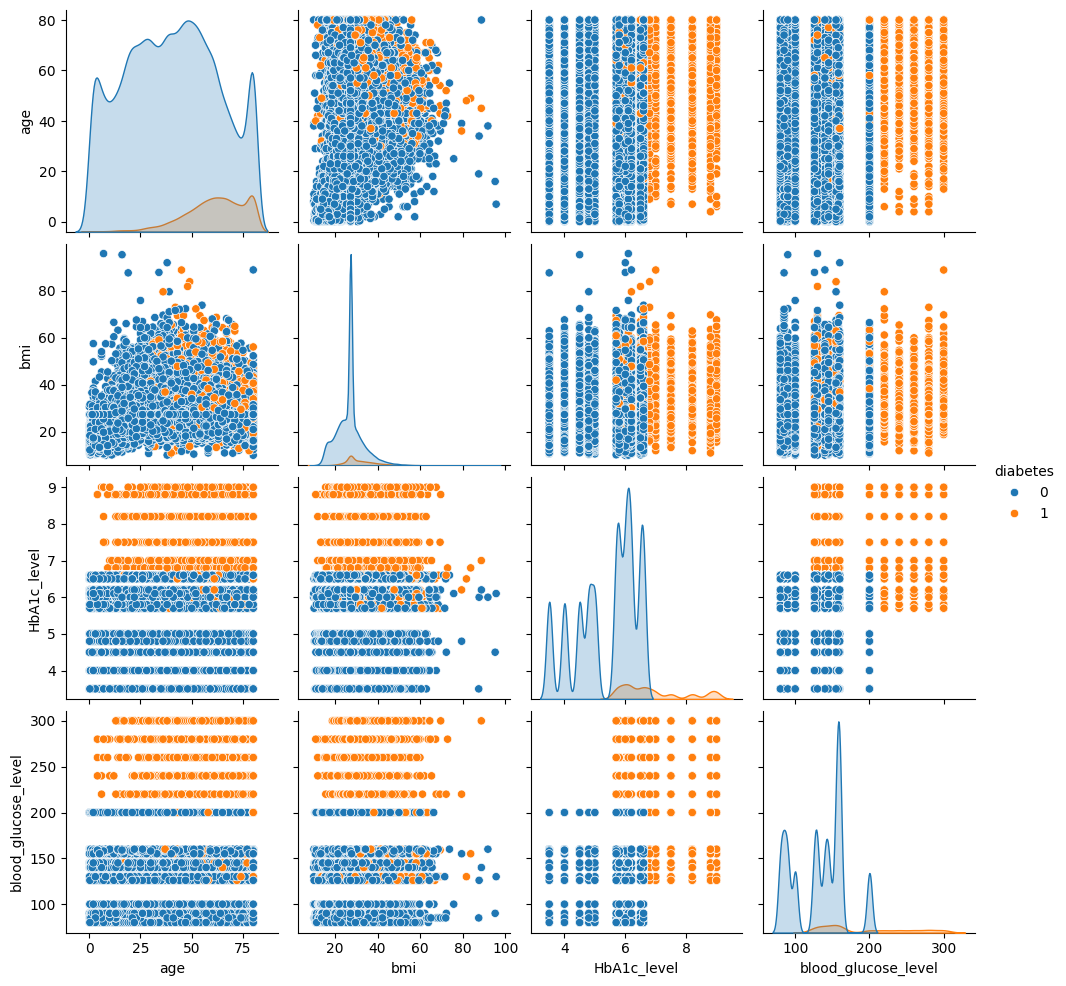

In [ ]:
# Create pairplot
pdf = df.toPandas()
pdf = pdf[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']]
sns.pairplot(pdf, hue='diabetes')
plt.show()

# Step4 Random Forest without Handle

In [97]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [98]:
train_df.groupBy("diabetes").count().show()
test_df.groupBy("diabetes").count().show()

+--------+-----+
|diabetes|count|
+--------+-----+
|       1| 6807|
|       0|73094|
+--------+-----+

+--------+-----+
|diabetes|count|
+--------+-----+
|       1| 1693|
|       0|18406|
+--------+-----+



In [99]:
# Train the Random Forest classifier
rf = RandomForestClassifier(labelCol="diabetes", featuresCol="features", probabilityCol="probabilities")
model = rf.fit(train_df)

In [100]:
# Use the trained model to make predictions on test_df
predictions1 = model.transform(test_df)

# Print out the schema of the predictions DataFrame
predictions1.printSchema()

# Show the first 10 rows of the predictions DataFrame with the diabetes, prediction, and probabilities columns
predictions1.select("diabetes", "prediction", "probabilities").show(10, truncate=False)

root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- gender_index: double (nullable = false)
 |-- smoking_history_index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probabilities: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------+----------+-----------------------------------------+
|diabetes|prediction|probabilities                            |
+--------+----------+-----------------------------------------+
|0       |0.0       |[0.9790634746389204,0.020936525361079643]|
|0       |0.0       |[0.9747831733773561,0.02521682662264401] |
|0       |0.0       |[0.9800453846828956,0.019954615317104407]|
|0       |0.0       |[0.9747831733773561,

In [101]:
from sklearn.metrics import confusion_matrix
true_labels = predictions1.select("diabetes").rdd.map(lambda x: x[0]).collect()

predicted_labels1 = predictions1.select("prediction").rdd.map(lambda x: x[0]).collect()

cm1 = confusion_matrix(true_labels, predicted_labels1)
print("Confusion Matrix:")
print(cm1)

Confusion Matrix:
[[18406     0]
 [  559  1134]]


In [102]:
TN1 = cm1[0, 0]
FP1 = cm1[0, 1]
FN1 = cm1[1, 0]
TP1 = cm1[1, 1]

# Calculate Precision
precision1 = TP1 / (TP1 + FP1)

# Calculate Recall
recall1 = TP1 / (TP1 + FN1)

# Calculate F1 score
f1_score1 = 2 * (precision1 * recall1) / (precision1 + recall1)

# Calculate Accuracy
accuracy1 = (TP1 + TN1) / np.sum(cm1)

print("Precision:", precision1)
print("Recall:", recall1)
print("F1 Score:", f1_score1)
print("Accuracy:", accuracy1)

Precision: 1.0
Recall: 0.6698168930891908
F1 Score: 0.8022638839759463
Accuracy: 0.9721876710284094


In [103]:
from sklearn.metrics import roc_auc_score
from pyspark.sql import Row

def get_auc(model, test_df):

    # Make predictions on the test set
    predictions = model.transform(test_df)

    # Extract probabilities and true labels
    probabilities = predictions.select("probabilities").rdd.map(lambda x: x[0][1]).collect()
    true_labels = predictions.select("diabetes").rdd.map(lambda x: x[0]).collect()

    # Calculate AUC score
    auc_ = roc_auc_score(true_labels, probabilities)

    return auc_, probabilities

# Using the get_auc function with your trained Random Forest model
auc_score, probabilities = get_auc(model, test_df)
print("AUC Score:", auc_score)
print("Predicted Probabilities:", probabilities)

AUC Score: 0.9553495069117334
Predicted Probabilities: [0.020936525361079643, 0.02521682662264401, 0.019954615317104407, 0.02521682662264401, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.03245707879900521, 0.015674314055540033, 0.02521682662264401, 0.015674314055540033, 0.019954615317104407, 0.020936525361079643, 0.02521682662264401, 0.020936525361079643, 0.019954615317104407, 0.020936525361079643, 0.020936525361079643, 0.02521682662264401, 0.02521682662264401, 0.02521682662264401, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.02521682662264401, 0.02521682662264401, 0.02521682662264401, 0.02521682662264401, 0.02521682662264401, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.02521682662264401, 0.02521682662264401, 0.019954615317104407, 0.02521682662264401, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.019954615317104407, 0.019954615317

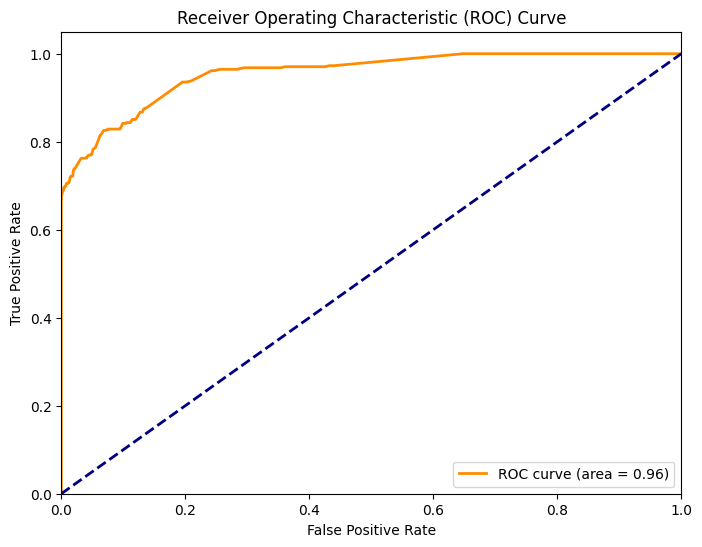

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.sql import Row

def plot_roc_curve(model, test_df):

    # Make predictions on the test set
    predictions1 = model.transform(test_df)

    # Extract probabilities and true labels
    probabilities = predictions1.select("probabilities").rdd.map(lambda x: x[0][1]).collect()
    true_labels = predictions1.select("diabetes").rdd.map(lambda x: x[0]).collect()

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(model, test_df)

#Step5 Random Forest with optimal threshold

In [105]:
# Define Function for finding optimal threshold
from sklearn.metrics import roc_curve

def select_prob_cutoff(self, y_true, y_probs, plot=False):

        fpr, tpr, threshold = roc_curve(y_true, y_probs)
        i = np.arange(len(tpr))
        roc = pd.DataFrame(
            {
                "tf": pd.Series(tpr - (1 - fpr), index=i),
                "threshold": pd.Series(threshold, index=i),
            }
        )
        roc_t = roc.loc[(roc.tf - 0).abs().argsort()[:1]]

        if plot == True:
            png_path = "Threshold_ROC.png"

            roc["fpr"] = pd.Series(fpr, index=i)
            roc["tpr"] = pd.Series(tpr, index=i)
            roc["1-fpr"] = pd.Series(1 - fpr, index=i)
            fig, ax = plt.subplots()
            plt.plot(roc["tpr"], label="tpr")
            plt.plot(roc["1-fpr"], label="1-fpr")
            plt.legend(loc="best")
            plt.xlabel("1-False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristics")
            plt.tight_layout()
            plt.savefig(png_path, dpi=250)

        return list(roc_t["threshold"])

y_true = predictions1.select("diabetes").rdd.map(lambda x: x[0]).collect()
y_probs = predictions1.select("probabilities").rdd.map(lambda x: x[0][1]).collect()

# Finding optimal threshold
select_prob_cutoff(predictions1, y_true, y_probs, plot=False)

[0.04303289922114008]

In [106]:
optimal_threshold = 0.04303289922114008

In [107]:
import numpy as np

# predict test_df use optimal threshold.
predicted_labels = np.where(np.array(probabilities) > optimal_threshold, 1, 0)

true_labels = predictions1.select("diabetes").rdd.map(lambda x: x[0]).collect()

In [108]:
#calculate confusion matrix for the predictions using optimal threshold.
cm2 = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm2)

Confusion Matrix:
[[16007  2399]
 [  225  1468]]


In [109]:
# Calculate TN, FP, FN, TP for the predictions using optimal threshold.
TN2 = cm2[0, 0]
FP2 = cm2[0, 1]
FN2 = cm2[1, 0]
TP2 = cm2[1, 1]

# Calculate Precision
precision2 = TP2 / (TP2 + FP2)

# Calculate Recall
recall2 = TP2 / (TP2 + FN2)

# Calculate F1 score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)

# Calculate Accuracy
accuracy2 = (TP2 + TN2) / np.sum(cm2)

print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f1_score2)
print("Accuracy:", accuracy2)


Precision: 0.3796224463408327
Recall: 0.8670998227997637
F1 Score: 0.5280575539568346
Accuracy: 0.8694462411065227


# Step6: Importance of Variables

In [110]:
# Retrieve feature importances
importances = model.featureImportances.toArray().tolist()

In [111]:
# Map importances to feature names
feature_names = assembler.getInputCols()
feature_importance_dict = dict(zip(feature_names, importances))

# Print feature importances
print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance}")

Feature Importances:
age: 0.015021896870945064
hypertension: 0.01802952038534944
heart_disease: 0.00192849303576267
bmi: 0.010783309779632965
HbA1c_level: 0.5177478189034295
blood_glucose_level: 0.4364889610248806
gender_index: 0.0
smoking_history_index: 0.0
